# Visualization of grid generation results

In [155]:
from syngrid.GridGenerator import GridGenerator
from syngrid import pgReaderWriter
import geopandas as gpd
import contextily as cx
from matplotlib import pyplot as plt
from shapely import linestrings

In [156]:
plz = "81671"
gg = GridGenerator(plz=plz)
pg = gg.pgr

PgReaderWriter is constructed. 
Version: 11.1 (already exists)
Parameter tables are inserted
PgReaderWriter closed.
PgReaderWriter closed.


## Postcode area

In [157]:
postcode_gdf = pg.getGeoDataFrame(table="postcode_result", id=plz)
postcode_gdf

,version_id,id,siedlungstyp,geom,hausabstand
0,11.1,81671,2,"MULTIPOLYGON (((4440242.781 2780282.060, 44403...",38.0


[]

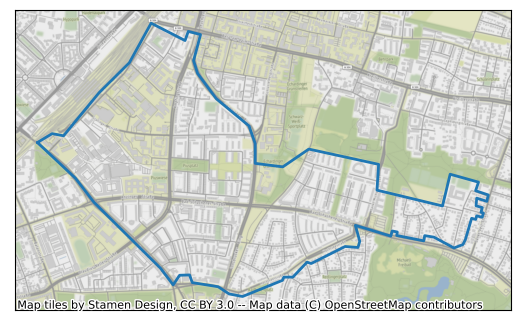

In [158]:
fig, ax = plt.subplots()
ax = postcode_gdf.boundary.plot(ax=ax, figsize=(10, 10), linewidth=2,)
cx.add_basemap(ax, crs=postcode_gdf.crs.to_string())
ax.set_xticks([])
ax.set_yticks([])

## Buildings

In [159]:
buildings_gdf = pg.getGeoDataFrame(table="buildings_result",in_loadarea_cluster=int(plz))
buildings_gdf.head()

,version_id,osm_id,area,type,geom,houses_per_building,center,in_loadarea,peak_load_in_kw,in_loadarea_cluster,vertice_id,in_building_cluster,k_mean_cluster,floors,connection_point
0,11.1,205485842,179.571518,MFH,"MULTIPOLYGON (((4443131.675 2779741.651, 44431...",3,0101000020DB0B00000318984B01F350414B716A4C3035...,None,90.0,81671,243,0,1,1,244
1,11.1,205590209,107.969821,SFH,"MULTIPOLYGON (((4443074.670 2779649.684, 44430...",1,0101000020DB0B000042851549F2F250416F11E0A60235...,None,30.0,81671,252,0,1,1,253
2,11.1,205485092,110.167215,SFH,"MULTIPOLYGON (((4443038.873 2779687.765, 44430...",1,0101000020DB0B0000388909ABE9F25041078655F41435...,None,30.0,81671,281,0,1,1,282
3,11.1,182831111,107.590308,SFH,"MULTIPOLYGON (((4443189.320 2779923.358, 44431...",1,0101000020DB0B0000221839DC0EF35041C6EB1AEA8B35...,None,30.0,81671,291,0,1,1,292
4,11.1,205590683,99.036347,SFH,"MULTIPOLYGON (((4443147.572 2779802.713, 44431...",1,0101000020DB0B0000126DB33604F35041679EC1155035...,None,30.0,81671,333,0,1,2,334


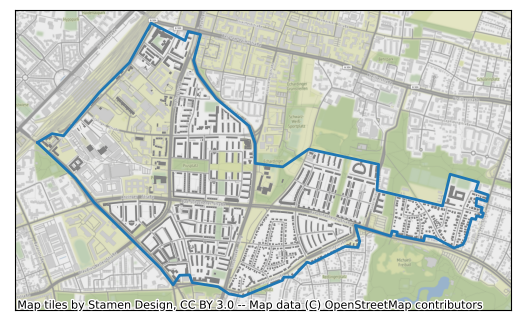

<Figure size 640x480 with 0 Axes>

In [160]:
ax = buildings_gdf.plot(ax=ax, legend=True, color="grey")
fig

## Building clusters

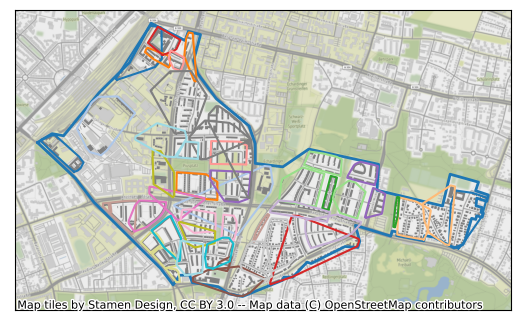

<Figure size 640x480 with 0 Axes>

In [161]:
buildings_gdf.dissolve(by="in_building_cluster").convex_hull.boundary.plot(ax=ax, cmap="tab20")
fig

This seems messy.
Try to color the buildings instead

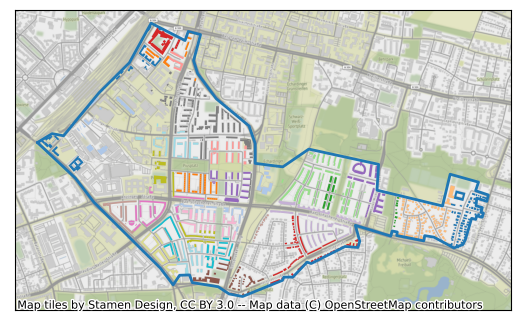

In [162]:
fig, ax = plt.subplots()
ax = postcode_gdf.boundary.plot(ax=ax, figsize=(10, 10), linewidth=2,)
cx.add_basemap(ax, crs=postcode_gdf.crs.to_string())
ax.set_xticks([])
ax.set_yticks([])
ax = buildings_gdf.plot(ax = ax, column="in_building_cluster", cmap="tab20")

Let's number the clusters

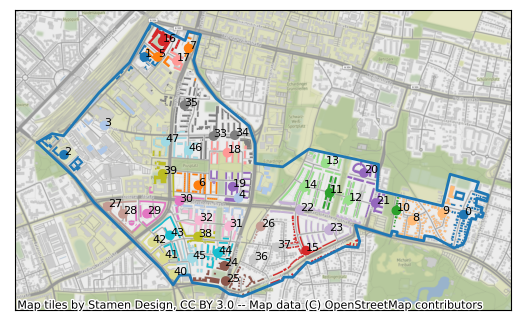

<Figure size 640x480 with 0 Axes>

In [163]:
buildings_gdf.dissolve(by="in_building_cluster").centroid.plot(ax=ax, cmap="tab20")
for  index, row in buildings_gdf.dissolve(by="in_building_cluster").centroid.items():
        x = row.x
        y = row.y
        ax.text(x, y, index, fontsize=8)
fig

## One LV grid
We can now focus on one building cluster.

In [164]:
buildings_8_gdf = buildings_gdf[buildings_gdf.in_building_cluster == 8]
len(buildings_8_gdf)

59

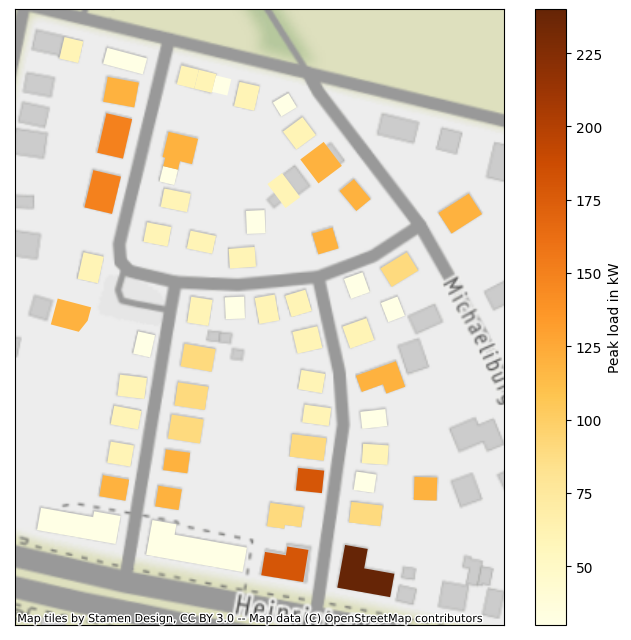

In [165]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xticks([])
ax.set_yticks([])
ax = buildings_8_gdf.plot(ax = ax, column="peak_load_in_kw", cmap="YlOrBr",
                          legend=True,legend_kwds={'label': "Peak load in kW"})
cx.add_basemap(ax, crs=buildings_8_gdf.crs.to_string(), zoom=17)

### Transformer

In [166]:
trafo_gdf = pg.getGeoDataFrame(table="transformer_positions", loadarea_cluster=int(plz), building_cluster=8)
trafo_gdf

,version_id,loadarea_cluster,k_mean_cluster,building_cluster,geom,ogc_fid,comment
0,11.1,81671,1,8,POINT (4442793.356 2779789.886),2034,on_way


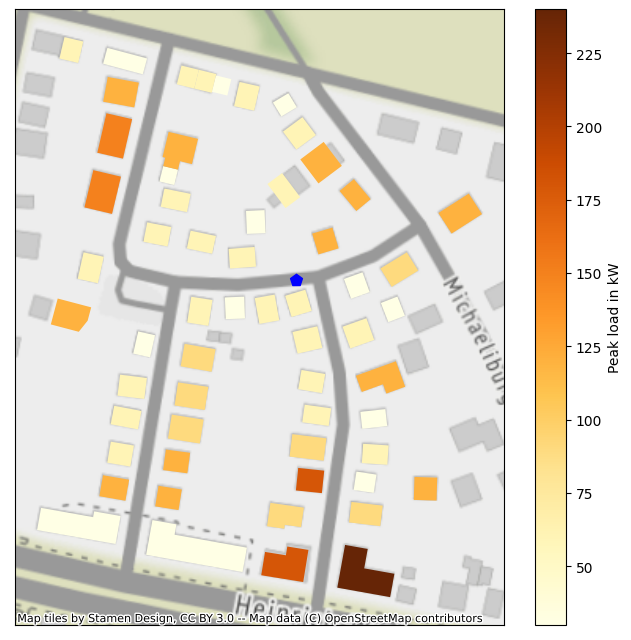

In [167]:
ax.scatter(trafo_gdf.loc[0].geom.x, trafo_gdf.loc[0].geom.y, marker=(5,0), s=80, color="blue", label="Transformer")
fig

## Streets

<AxesSubplot: >

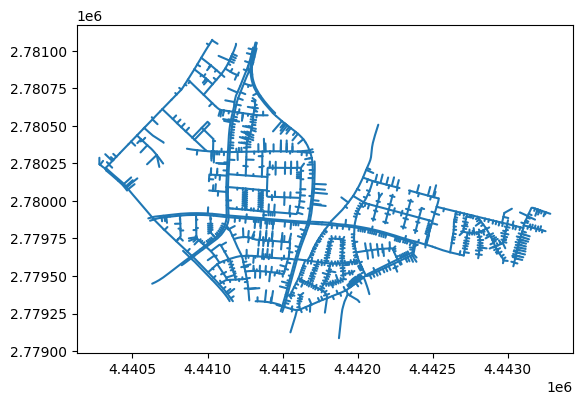

In [168]:
ways_gdf = pg.getGeoDataFrame(table="ways_result", plz=f"'{plz}'")
ways_gdf.plot()

We can filter ways around the cluster 8

In [169]:
# The area around cluster 
cluster_region = buildings_8_gdf.dissolve().convex_hull.buffer(50)
cluster_region_gdf = gpd.GeoDataFrame(geometry=cluster_region)
cluster_region_gdf

,geometry
0,"POLYGON ((4442886.061 2779607.581, 4442883.692..."


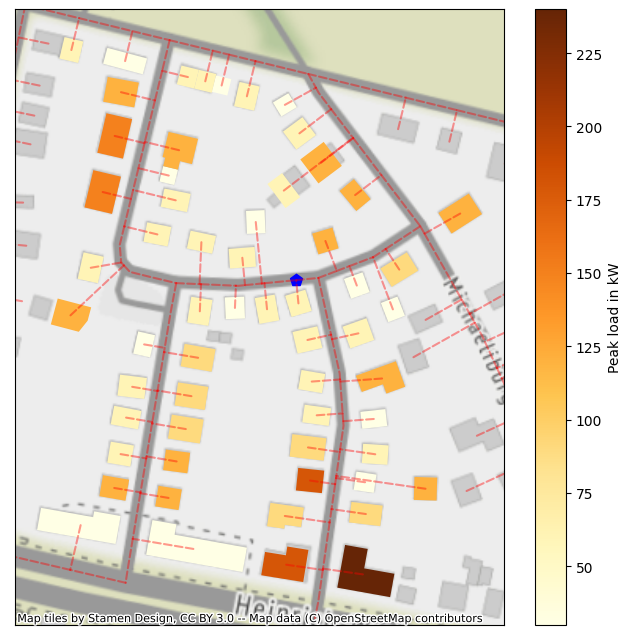

<Figure size 640x480 with 0 Axes>

In [170]:
ways_8_gdf = gpd.tools.sjoin(ways_gdf, cluster_region_gdf, how='inner')
ax = ways_8_gdf.plot(ax=ax, edgecolor="red", linestyle="--", alpha=0.4, label="Streets")
fig

## Generated Grid

In [171]:
net = pg.read_net(plz=plz, kcid=1, bcid=8)
net

This pandapower network includes the following parameter tables:
   - bus (120 elements)
   - load (156 elements)
   - ext_grid (1 element)
   - line (118 elements)
   - trafo (1 element)
   - line_geodata (118 elements)
   - bus_geodata (120 elements)

In [172]:
# data but no coordinates
net.line.head()

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service
0,Line to 254,NYY 4x16 SE,8,61,0.011263,1.15,0.09,0.0,0.0,0.103,1.0,1,None,True
1,Line to 287,NYY 4x16 SE,4,62,0.031306,1.15,0.09,0.0,0.0,0.103,1.0,1,None,True
2,Line to 1279,NYY 4x16 SE,58,72,0.015629,1.15,0.09,0.0,0.0,0.103,1.0,1,None,True
3,Line to 1480,NYY 4x16 SE,41,75,0.015795,1.15,0.09,0.0,0.0,0.103,1.0,1,None,True
4,Line to 1482,NYY 4x16 SE,46,76,0.017837,1.15,0.09,0.0,0.0,0.103,1.0,1,None,True


In [173]:
# coordinates but no data
net.line_geodata.head()

,coords
0,"[[11.634771739630953, 48.11951579188109], [11...."
1,"[[11.634948386345942, 48.11952330875271], [11...."
2,"[[11.634105052266275, 48.120686862413834], [11..."
3,"[[11.634126071872995, 48.12006151169197], [11...."
4,"[[11.634173506279463, 48.12018070777122], [11...."


The index is shared -> join on index

In [174]:
net.line_gdf = gpd.GeoDataFrame(net.line.copy(), geometry=net.line_geodata.coords.map(linestrings), crs="EPSG:4326").to_crs(buildings_8_gdf.crs.to_string())
net.line_gdf.head()

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service,geometry
0,Line to 254,NYY 4x16 SE,8,61,0.011263,1.15,0.09,0.0,0.0,0.103,1.0,1,None,True,"LINESTRING (4442762.828 2779787.047, 4442762.3..."
1,Line to 287,NYY 4x16 SE,4,62,0.031306,1.15,0.09,0.0,0.0,0.103,1.0,1,None,True,"LINESTRING (4442775.965 2779788.173, 4442772.8..."
2,Line to 1279,NYY 4x16 SE,58,72,0.015629,1.15,0.09,0.0,0.0,0.103,1.0,1,None,True,"LINESTRING (4442710.375 2779916.072, 4442706.6..."
3,Line to 1480,NYY 4x16 SE,41,75,0.015795,1.15,0.09,0.0,0.0,0.103,1.0,1,None,True,"LINESTRING (4442713.438 2779846.621, 4442728.7..."
4,Line to 1482,NYY 4x16 SE,46,76,0.017837,1.15,0.09,0.0,0.0,0.103,1.0,1,None,True,"LINESTRING (4442716.685 2779859.943, 4442734.0..."


<AxesSubplot: >

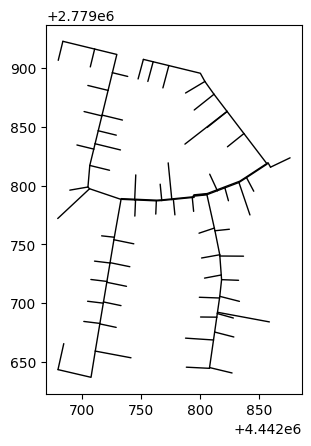

In [175]:
net.line_gdf.plot(edgecolor="black", linewidth=1)

OK

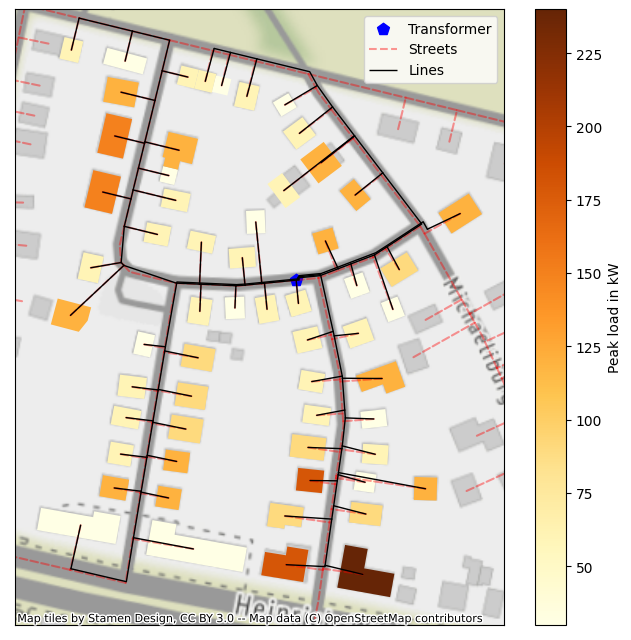

<Figure size 640x480 with 0 Axes>

In [176]:
ax = net.line_gdf.plot(ax=ax, edgecolor="black", linewidth=1, label="Lines")
ax.legend()
fig